In [400]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
from PIL import Image, ImageOps
from tensorflow.keras import layers, models
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [401]:
import os
from PIL import Image, UnidentifiedImageError

# 图片所在的根目录
root_dir = 'trafficsigns_dataset'  # 请替换成实际的路径

# 用于存储按两层标签分隔的图片的嵌套字典
images_by_label = {}

# 用于遍历数据集并加载图像及其标签的函数
def load_images_and_labels(root_dir):
    # 遍历根目录下的每个子目录（第一层）
    for sub_dir in os.listdir(root_dir):
        sub_dir_path = os.path.join(root_dir, sub_dir)
        
        # 如果子目录确实是一个目录
        if os.path.isdir(sub_dir_path):
            # 初始化第一层标签键
            images_by_label[sub_dir] = {}
            
            # 再次遍历该子目录下的文件夹（第二层，具体的标签）
            for label_dir in os.listdir(sub_dir_path):
                label_dir_path = os.path.join(sub_dir_path, label_dir)
                
                # 如果第二层也是一个目录
                if os.path.isdir(label_dir_path):
                    # 初始化第二层标签键
                    images_by_label[sub_dir][label_dir] = []
                    
                    # 遍历第二层目录下的所有图像文件
                    for image_filename in os.listdir(label_dir_path):
                        # 忽略 .DS_Store 文件
                        if image_filename == '.DS_Store':
                            continue
                        image_path = os.path.join(label_dir_path, image_filename)
                        try:
                            images_by_label[sub_dir][label_dir].append(image_path)
                        except UnidentifiedImageError:
                            # 如果无法识别图像，打印出错信息
                            print(f"Cannot identify image file '{image_path}'")

# 载入图像数据和标签
load_images_and_labels(root_dir)

# 打印每个类别的图像数量
for sub_dir, labels in images_by_label.items():
    for label, images in labels.items():
        print(f"{sub_dir}/{label}: {len(images)} images")


diamond/rightofway: 282 images
hex/stop: 43 images
square/laneend: 118 images
square/parking: 276 images
square/continue: 199 images
square/crossing: 95 images
triangle/giveway: 231 images
triangle/warning: 695 images
round/traveldirection: 124 images
round/limitedtraffic: 125 images
round/speed: 316 images
round/roundabout: 98 images
round/noentry: 375 images
round/noparking: 242 images
round/bicycle: 285 images
round/trafficdirective: 195 images


28no Unusual

In [402]:
def get_image_sizes(root_dir):
    sizes = []
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith('.png') or file.lower().endswith('.jpg'):
                try:
                    with Image.open(os.path.join(subdir, file)) as img:
                        sizes.append(img.size)
                except (IOError, UnidentifiedImageError):
                    continue
    return sizes

image_sizes = get_image_sizes(root_dir)

sizes_np = np.array(image_sizes)
min_size = sizes_np.min(axis=0)
max_size = sizes_np.max(axis=0)
mean_size = sizes_np.mean(axis=0)
std_dev_size = sizes_np.std(axis=0)
median_size = np.median(sizes_np, axis=0)

min_size, max_size, mean_size, std_dev_size, median_size

(array([28, 28]),
 array([28, 28]),
 array([28., 28.]),
 array([0., 0.]),
 array([28., 28.]))

In [403]:
train_data = {}
test_data = {}
validation_data = {}

for first_level, second_level_dict in images_by_label.items():
    train_data[first_level] = {}
    validation_data[first_level] = {}
    test_data[first_level] = {}
    
    for label, image_paths in second_level_dict.items():
        temp_images, test_images = train_test_split(image_paths, test_size=0.2, random_state=42)
        train_images, val_images = train_test_split(temp_images, test_size=0.2, random_state=42)
        
        # Save split data
        train_data[first_level][label] = train_images
        test_data[first_level][label] = test_images
        validation_data[first_level][label] = val_images


In [404]:
def create_dataframe_for_16_class(data_dict):
    rows = []
    for first_level, second_level_dict in data_dict.items():
        for label, image_paths in second_level_dict.items():
            for path in image_paths:
                rows.append({'ImagePath': path, 'Label': label})
    return pd.DataFrame(rows)

def create_dataframe_for_5_class(data_dict):
    rows = []
    for first_level, second_level_dict in data_dict.items():
        for label, image_paths in second_level_dict.items():
            for path in image_paths:
                rows.append({'ImagePath': path, 'Label': first_level})
    return pd.DataFrame(rows)

train_df = create_dataframe_for_16_class(train_data)
test_df = create_dataframe_for_16_class(test_data)
validation_df = create_dataframe_for_16_class(validation_data)

In [405]:
batch_size = 64

In [406]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='ImagePath',
    y_col='Label',
    color_mode='grayscale',
    target_size=(28, 28),  
    batch_size=batch_size,
    class_mode='categorical',  # 如果是多分类问题
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='ImagePath',
    y_col='Label',
    color_mode='grayscale',
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',  # 如果是多分类问题
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='ImagePath',
    y_col='Label',
    color_mode='grayscale',
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',  # 如果是多分类问题
    shuffle=False
)

Found 2358 validated image filenames belonging to 16 classes.
Found 596 validated image filenames belonging to 16 classes.
Found 745 validated image filenames belonging to 16 classes.


## Transfer data to suit scikit-learn

In [407]:
import numpy as np

def get_data_from_generator(generator):
    batches = []
    labels = []
    # 迭代生成器收集数据和标签
    for batch, label in generator:
        batches.append(batch)
        labels.append(label)
        if len(batches) >= len(generator):
            break  # 确保不会无限迭代
    return np.vstack(batches), np.vstack(labels)


X_train, y_train = get_data_from_generator(train_generator)
X_val, y_val = get_data_from_generator(val_generator)
X_test, y_test = get_data_from_generator(test_generator)

## Decision Tree

In [408]:
# 假设X_train和X_val原始形状为[样本数, 28, 28, 1] - 例如从图像生成器中提取的

# 重塑X_train和X_val为二维数组，每个图像一行
X_train = X_train.reshape(X_train.shape[0], -1)  # -1会根据剩余维度计算所需大小
X_val = X_val.reshape(X_val.shape[0], -1)

# 如果使用get_data_from_generator函数提取数据，确保先调整函数或数据后重塑
# 示例，确保数据从生成器正确提取和转换后
X_train, y_train = get_data_from_generator(train_generator)
X_train = X_train.reshape(X_train.shape[0], -1)

X_val, y_val = get_data_from_generator(val_generator)
X_val = X_val.reshape(X_val.shape[0], -1)

# 训练决策树模型
tree_model = DecisionTreeClassifier(max_depth=10)
tree_model.fit(X_train, y_train)

# 在验证集上评估模型
y_pred_val = tree_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))

Validation Accuracy: 0.7684563758389261


## Random Forest

In [409]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 初始化随机森林模型
rf_model = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=42)

# 训练模型
rf_model.fit(X_train, y_train)

# 使用验证集进行模型评估
y_pred_val = rf_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))

Validation Accuracy: 0.7751677852348994


## SVM

In [410]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# 假设 y_train 和 y_val 是 one-hot 编码的，形状为 (样本数, 类别数)
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

# 初始化并应用标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 初始化 SVM 模型
svm_model = SVC(kernel='rbf', C=1.0, gamma='auto', max_iter=1000)

# 训练 SVM 模型
svm_model.fit(X_train_scaled, y_train)

# 在验证集上评估 SVM 模型
y_pred_val = svm_model.predict(X_val_scaled)
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))

Validation Accuracy: 0.9379194630872483


## MLP Baseline Model for Multi-class Task


In [411]:
num_classes = 16
input_shape = (28, 28)
baseline_categorical = tf.keras.models.Sequential([
    tf.keras.Input(shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [412]:
baseline_categorical.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

In [413]:
epochs = 50
history_baseline_categorical = baseline_categorical.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

Epoch 1/50


/Users/tianbai/anaconda3/envs/DL/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.3236 - loss: 2.3063 - val_accuracy: 0.7047 - val_loss: 1.1694
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7566 - loss: 1.0400 - val_accuracy: 0.7869 - val_loss: 0.7918
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8425 - loss: 0.6848 - val_accuracy: 0.8977 - val_loss: 0.5566
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8809 - loss: 0.5287 - val_accuracy: 0.9044 - val_loss: 0.4889
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9002 - loss: 0.4680 - val_accuracy: 0.9211 - val_loss: 0.4001
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9176 - loss: 0.3636 - val_accuracy: 0.9463 - val_loss: 0.3310
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9311 - loss: 0.3301 - val_accuracy: 0.9581 - val_loss: 0.3005
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9476 - loss: 0.2746 - val_accuracy: 0.9295 - val_loss: 0.

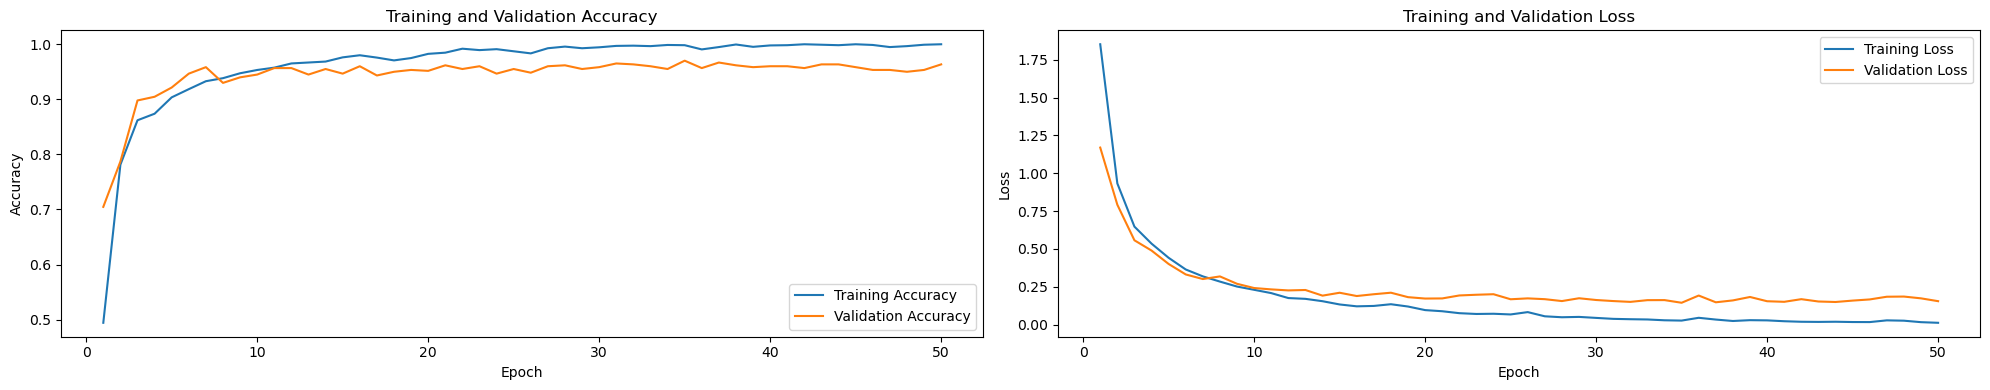

In [414]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    根据Keras模型的History对象绘制训练和验证的指标。

    参数:
    - history: 从fit方法返回的History对象。
    """
    epochs_range = range(1, len(history.history['accuracy']) + 1)  # 假设至少有'accuracy'这个指标
    metrics = [key for key in history.history.keys() if not key.startswith("val_")]  # 获取所有非验证集的指标
    _, axes = plt.subplots(1, len(metrics), figsize=(20, 4))  # 根据指标数量动态调整subplot数量

    for idx, metric in enumerate(metrics):
        # 在每个subplot中画出当前指标的训练和验证曲线
        axes[idx].plot(epochs_range, history.history[metric], label=f'Training {metric.capitalize()}')
        axes[idx].plot(epochs_range, history.history[f"val_{metric}"], label=f'Validation {metric.capitalize()}')
        axes[idx].legend()
        axes[idx].set_title(f'Training and Validation {metric.capitalize()}')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric.capitalize())
    
    plt.tight_layout()
    plt.show()

# 假设 history_baseline_categorical 是你的MLP模型训练历史对象
# 调用函数绘图
plot_training_history(history_baseline_categorical)


## Modify images to make classify more difficult

In [415]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # 旋转范围（角度），可以调整范围，如 20-40
    width_shift_range=0.1,  # 横向平移范围
    height_shift_range=0.1,  # 纵向平移范围
    shear_range=0.1,  # 剪切范围
    zoom_range=0.1,  # 缩放范围
    horizontal_flip=True,  # 水平翻转
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='ImagePath',
    y_col='Label',
    color_mode='grayscale',
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='ImagePath',
    y_col='Label',
    color_mode='grayscale',
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='ImagePath',
    y_col='Label',
    color_mode='grayscale',
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=False
)

Found 2358 validated image filenames belonging to 16 classes.
Found 596 validated image filenames belonging to 16 classes.
Found 745 validated image filenames belonging to 16 classes.


## SVM Model with modified dataset

In [416]:
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

def get_data_from_generator(generator):
    batches = []
    labels = []
    # 迭代生成器收集数据和标签
    for batch, label in generator:
        batches.append(batch)
        labels.append(label)
        if len(batches) >= len(generator):
            break  # 确保不会无限迭代
    return np.vstack(batches), np.vstack(labels)

X_train, y_train = get_data_from_generator(train_generator)
X_val, y_val = get_data_from_generator(val_generator)
X_test, y_test = get_data_from_generator(test_generator)

# 重塑数据以适应 StandardScaler 的输入需求
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# 假设 y_train 和 y_val 是 one-hot 编码的，形状为 (样本数, 类别数)
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

# 初始化并应用标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 初始化 SVM 模型
svm_model = SVC(kernel='rbf', C=1.0, gamma='auto', max_iter=1000)

# 训练 SVM 模型
svm_model.fit(X_train_scaled, y_train)

# 在验证集上评估 SVM 模型
y_pred_val = svm_model.predict(X_val_scaled)
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))


Validation Accuracy: 0.709731543624161


## MLP Model with modified dataset

In [417]:
num_classes = 16
input_shape = (28, 28)
baseline_categorical = tf.keras.models.Sequential([
    tf.keras.Input(shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [418]:
baseline_categorical.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

In [419]:
epochs = 50
history_baseline_categorical = baseline_categorical.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

Epoch 1/50


/Users/tianbai/anaconda3/envs/DL/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.1681 - loss: 0.3179 - val_accuracy: 0.4077 - val_loss: 0.2043
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3328 - loss: 0.2135 - val_accuracy: 0.5067 - val_loss: 0.1797
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3726 - loss: 0.1998 - val_accuracy: 0.5319 - val_loss: 0.1633
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4206 - loss: 0.1898 - val_accuracy: 0.6107 - val_loss: 0.1518
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4547 - loss: 0.1823 - val_accuracy: 0.6426 - val_loss: 0.1427
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5051 - loss: 0.1715 - val_accuracy: 0.6074 - val_loss: 0.1416
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4700 - loss: 0.1739 - val_accuracy: 0.6326 - val_loss: 0.1392
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4771 - loss: 0.1676 - val_accuracy: 0.6628 - val_loss: 0.

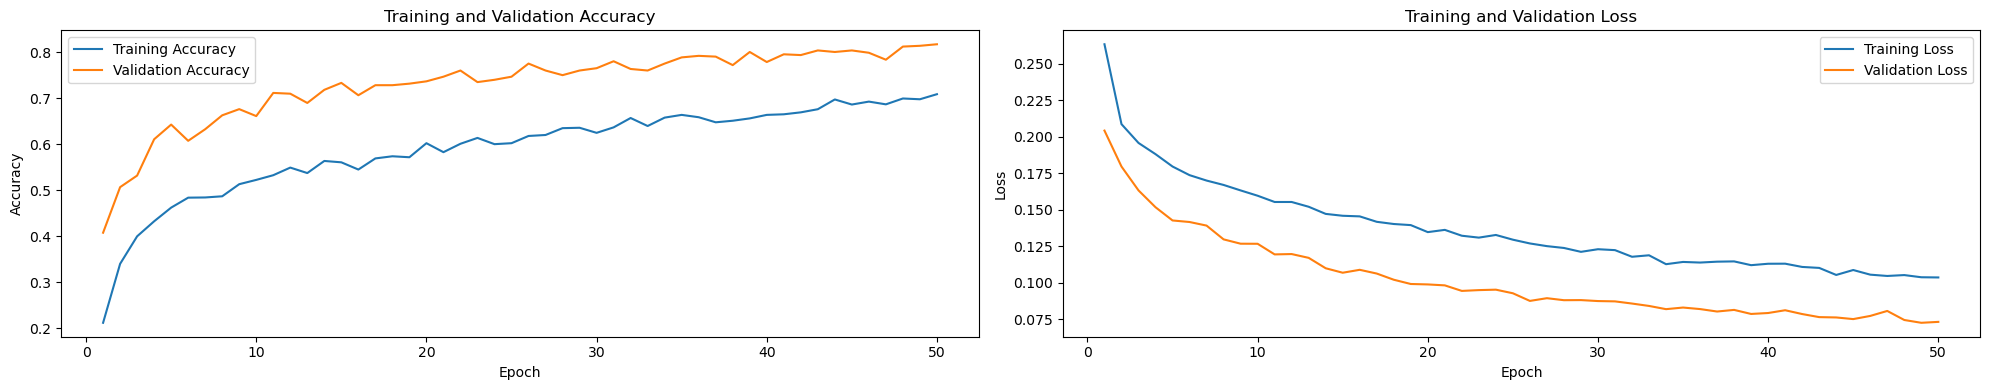

In [420]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    根据Keras模型的History对象绘制训练和验证的指标。

    参数:
    - history: 从fit方法返回的History对象。
    """
    epochs_range = range(1, len(history.history['accuracy']) + 1)  # 假设至少有'accuracy'这个指标
    metrics = [key for key in history.history.keys() if not key.startswith("val_")]  # 获取所有非验证集的指标
    _, axes = plt.subplots(1, len(metrics), figsize=(20, 4))  # 根据指标数量动态调整subplot数量

    for idx, metric in enumerate(metrics):
        # 在每个subplot中画出当前指标的训练和验证曲线
        axes[idx].plot(epochs_range, history.history[metric], label=f'Training {metric.capitalize()}')
        axes[idx].plot(epochs_range, history.history[f"val_{metric}"], label=f'Validation {metric.capitalize()}')
        axes[idx].legend()
        axes[idx].set_title(f'Training and Validation {metric.capitalize()}')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric.capitalize())
    
    plt.tight_layout()
    plt.show()

# 假设 history_baseline_categorical 是你的MLP模型训练历史对象
# 调用函数绘图
plot_training_history(history_baseline_categorical)


## CNN Model for Multi Class

In [421]:
from tensorflow.keras import models, layers

num_classes = 16  # 根据你的任务调整类别数

cnn_model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),  # 灰度图像输入，1 个通道
    layers.Conv2D(32, (3, 3), padding='same'),  # 第一卷积层，32 个滤波器
    layers.BatchNormalization(),  # 添加批归一化
    layers.Activation('relu'),  # 激活层
    layers.MaxPooling2D((2, 2)),  # 最大池化
    layers.Conv2D(64, (3, 3), padding='same'),  # 第二卷积层，64 个滤波器
    layers.BatchNormalization(),  # 添加批归一化
    layers.Activation('relu'),  # 激活层
    layers.MaxPooling2D((2, 2)),  # 最大池化
    layers.Conv2D(128, (3, 3), padding='same'),  # 第三卷积层，128 个滤波器
    layers.BatchNormalization(),  # 添加批归一化
    layers.Activation('relu'),  # 激活层
    layers.MaxPooling2D((2, 2)),  # 最大池化
    layers.Flatten(),  # 将卷积结果展平
    layers.Dense(512),  # 全连接层
    layers.BatchNormalization(),  # 添加批归一化
    layers.Activation('relu'),  # 激活层
    layers.Dense(num_classes, activation='softmax')  # 输出层，使用 softmax 激活
])

cnn_model.compile(
    loss='categorical_crossentropy',  # 使用多分类交叉熵损失
    optimizer=tf.keras.optimizers.Adam(),  # Adam 优化器
    metrics=['accuracy']  # 使用准确率作为指标
)


In [422]:
epochs = 50
history_cnn = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 211ms/step - accuracy: 0.4756 - loss: 1.7463 - val_accuracy: 0.0654 - val_loss: 2.7241
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.8443 - loss: 0.5385 - val_accuracy: 0.0654 - val_loss: 3.2384
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9064 - loss: 0.3300 - val_accuracy: 0.0654 - val_loss: 3.2067
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9153 - loss: 0.2868 - val_accuracy: 0.0721 - val_loss: 3.7872
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9439 - loss: 0.2054 - val_accuracy: 0.1493 - val_loss: 3.5883
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9467 - loss: 0.1896 - val_accuracy: 0.1611 - val_loss: 3.2916
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9362 - loss: 0.1881 - val_accuracy: 0.5117 - val_loss: 1.7652
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9572 - loss: 0.1341 - val_accuracy: 0.5218 -

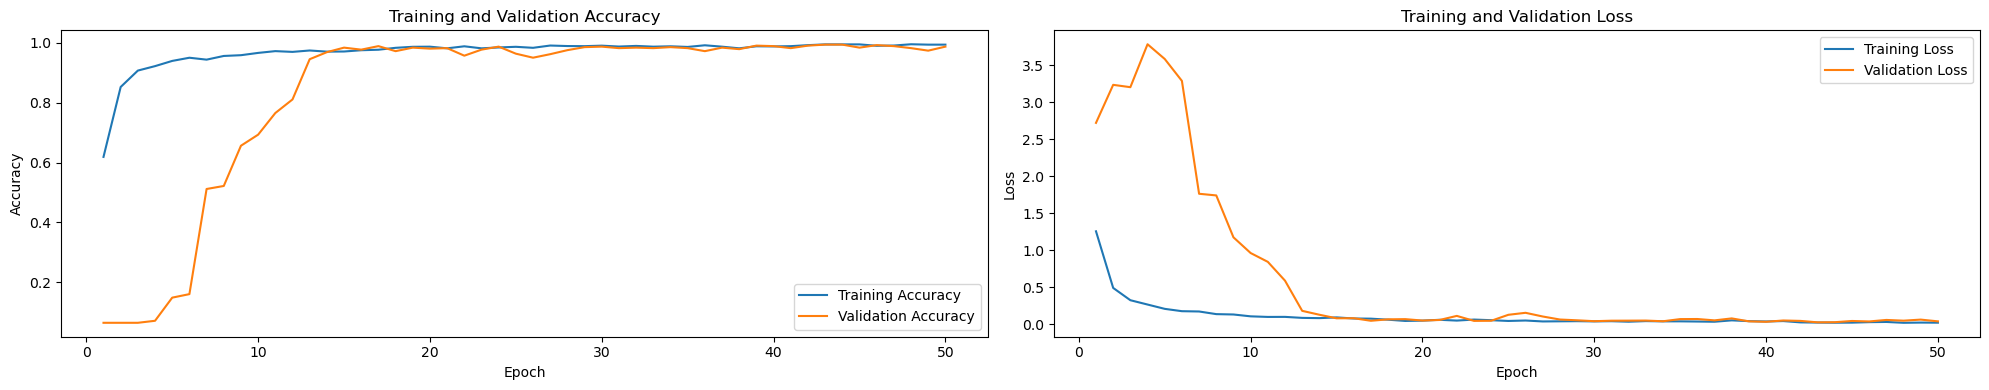

In [425]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    根据Keras模型的History对象绘制训练和验证的指标。

    参数:
    - history: 从fit方法返回的History对象。
    """
    epochs_range = range(1, len(history.history['accuracy']) + 1)  # 假设至少有'accuracy'这个指标
    metrics = [key for key in history.history.keys() if not key.startswith("val_")]  # 获取所有非验证集的指标
    _, axes = plt.subplots(1, len(metrics), figsize=(20, 4))  # 根据指标数量动态调整subplot数量

    for idx, metric in enumerate(metrics):
        # 在每个subplot中画出当前指标的训练和验证曲线
        axes[idx].plot(epochs_range, history.history[metric], label=f'Training {metric.capitalize()}')
        axes[idx].plot(epochs_range, history.history[f"val_{metric}"], label=f'Validation {metric.capitalize()}')
        axes[idx].legend()
        axes[idx].set_title(f'Training and Validation {metric.capitalize()}')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric.capitalize())
    
    plt.tight_layout()
    plt.show()

# 假设 history_baseline_categorical 是你的MLP模型训练历史对象
# 调用函数绘图
plot_training_history(history_cnn)
